# 1. Import packages

In [529]:
import gym
import gym_anytrading
# Stable baselines - rl stuff
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [530]:
df = pd.read_csv('gmedata.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', ascending=True, inplace=True)
df.set_index('Date', inplace=True)
df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(",", "")))
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-03-16,3.93,4.57,3.90,4.37,4866696.0
2020-03-17,4.40,4.65,4.11,4.23,3562210.0
2020-03-18,4.10,4.25,3.50,3.77,3651709.0
2020-03-19,3.71,4.20,3.55,4.19,5039539.0
2020-03-20,4.08,4.08,3.65,3.76,7722194.0


# 2.1 Add Custom Indicators

## 2.1.1. Install and Import New Dependencies

In [531]:
from gym_anytrading.envs import StocksEnv
from finta import TA

## 2.1.2. Calculate SMA, RSI and OBV

In [532]:
df['SMA'] = TA.SMA(df, 12)
df['RSI'] = TA.RSI(df)
df['OBV'] = TA.OBV(df)
df.fillna(0, inplace=True)

In [533]:
df.head(15)

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2020-03-16,3.93,4.57,3.90,4.37,4866696.0,0.000000,0.000000,0.0
2020-03-17,4.40,4.65,4.11,4.23,3562210.0,0.000000,0.000000,-3562210.0
2020-03-18,4.10,4.25,3.50,3.77,3651709.0,0.000000,0.000000,-7213919.0
2020-03-19,3.71,4.20,3.55,4.19,5039539.0,0.000000,43.394834,-2174380.0
2020-03-20,4.08,4.08,3.65,3.76,7722194.0,0.000000,29.351457,-9896574.0
2020-03-23,3.58,3.86,3.50,3.81,6009784.0,0.000000,32.102964,-3886790.0
2020-03-24,3.95,4.21,3.89,4.16,6805659.0,0.000000,47.512950,2918869.0
2020-03-25,4.15,4.49,4.04,4.17,3592059.0,0.000000,47.876947,6510928.0
2020-03-26,4.24,4.71,4.24,4.41,6210979.0,0.000000,55.799557,12721907.0


## 2.1.3. Create New Environments

In [534]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    return prices, signal_features

In [535]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env2 = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

In [536]:
env2.signal_features

array([[ 3.90000000e+00,  4.86669600e+06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.11000000e+00,  3.56221000e+06,  0.00000000e+00,
         0.00000000e+00, -3.56221000e+06],
       [ 3.50000000e+00,  3.65170900e+06,  0.00000000e+00,
         0.00000000e+00, -7.21391900e+06],
       [ 3.55000000e+00,  5.03953900e+06,  0.00000000e+00,
         4.33948339e+01, -2.17438000e+06],
       [ 3.65000000e+00,  7.72219400e+06,  0.00000000e+00,
         2.93514572e+01, -9.89657400e+06],
       [ 3.50000000e+00,  6.00978400e+06,  0.00000000e+00,
         3.21029638e+01, -3.88679000e+06],
       [ 3.89000000e+00,  6.80565900e+06,  0.00000000e+00,
         4.75129499e+01,  2.91886900e+06],
       [ 4.04000000e+00,  3.59205900e+06,  0.00000000e+00,
         4.78769470e+01,  6.51092800e+06],
       [ 4.24000000e+00,  6.21097900e+06,  0.00000000e+00,
         5.57995572e+01,  1.27219070e+07],
       [ 4.15000000e+00,  7.02476300e+06,  0.00000000e+00,
         4.93981406e+01

In [537]:
df.head()
print(df.shape)

(251, 8)


# 3. Build Environment and Train

In [538]:
env_maker = lambda: env2
env = DummyVecEnv([env_maker])

In [539]:
model = A2C('MlpLstmPolicy', env, verbose=1,tensorboard_log='./a2c_stocks')

In [540]:
# model.learn(total_timesteps=1000000)
# # save the model to a file
# model.save("a2c_stocks_RL_model")

In [541]:


# load the model from a file
model = A2C.load("a2c_stocks_RL_model")

Loading a model without an environment, this model cannot be trained until it has a valid environment.


# 4. Evaluation

In [542]:
start = 200
end = 250

### 4.1 RL Model

info {'total_reward': 220.29000000000002, 'total_profit': 59.21724460355676, 'position': 1}
info {'total_reward': 220.29000000000002, 'total_profit': 59.21724460355676, 'position': 1}
info {'total_reward': 358.04, 'total_profit': 129.91524899049796, 'position': 1}
info {'total_reward': 213.36, 'total_profit': 48.20053979621085, 'position': 1}
info {'total_reward': 213.36, 'total_profit': 48.20053979621085, 'position': 1}
info {'total_reward': 220.29000000000002, 'total_profit': 59.21724460355676, 'position': 1}
info {'total_reward': 227.11, 'total_profit': 55.287625658508645, 'position': 1}
info {'total_reward': 220.29000000000002, 'total_profit': 59.21724460355676, 'position': 1}
info {'total_reward': 208.04000000000002, 'total_profit': 41.51129120679414, 'position': 1}
info {'total_reward': 214.97000000000003, 'total_profit': 50.99910282323116, 'position': 1}
info {'total_reward': 213.36, 'total_profit': 48.20053979621085, 'position': 1}
info {'total_reward': 208.04000000000002, 'tot

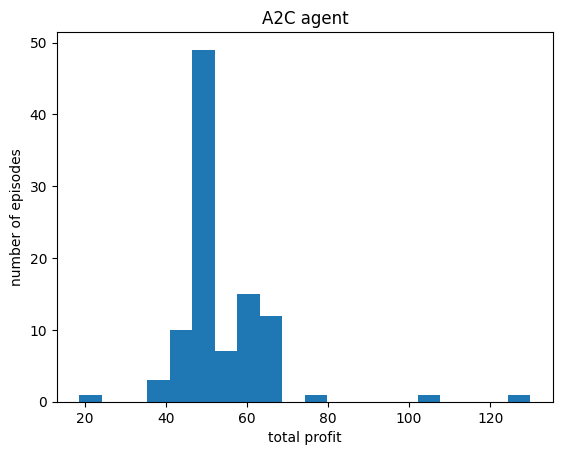

Average profit: 52.97426631742232
Max profit: 129.91524899049796
Min profit: 18.713423445633104
Variation in profits: 12.574279992617887


In [543]:
RL_profits = []
for _ in range(100):
    env = MyCustomEnv(df=df, window_size=12, frame_bound=(start,end))
    obs = env.reset()
    while True: 
        obs = obs[np.newaxis, ...]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        if done:
            print("info", info)
            break
    RL_profits.append(info['total_profit'])

# plot profits as a histogram
plt.hist(np.array(RL_profits), bins=20)
plt.xlabel('total profit')
plt.ylabel('number of episodes')
plt.title('A2C agent')
plt.show()

print("Average profit:", np.mean(RL_profits))
print("Max profit:", np.max(RL_profits))
print("Min profit:", np.min(RL_profits))
print("Variation in profits:", np.std(RL_profits))

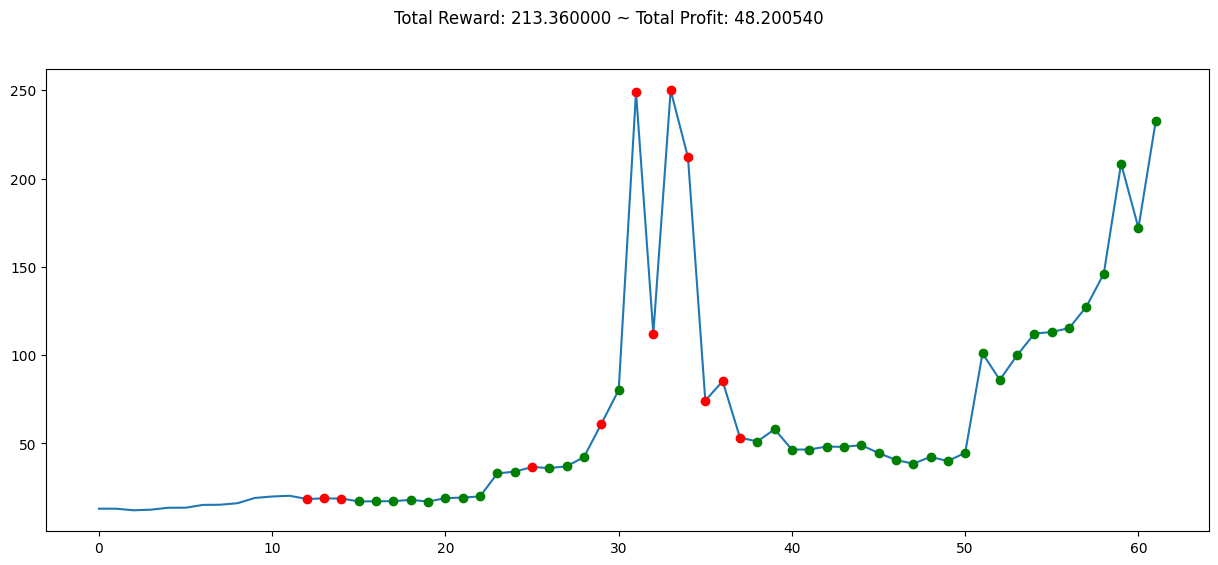

In [544]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()

### 4.2 Random Model

info {'total_reward': -168.29000000000002, 'total_profit': 0.401014631068544, 'position': 0}
info {'total_reward': 53.809999999999995, 'total_profit': 2.5498908313208957, 'position': 1}
info {'total_reward': 86.54, 'total_profit': 2.540409482218721, 'position': 0}
info {'total_reward': 50.96999999999998, 'total_profit': 1.954908625767858, 'position': 1}
info {'total_reward': -76.81000000000003, 'total_profit': 0.8635167774683955, 'position': 0}
info {'total_reward': 512.73, 'total_profit': 46.08024493371565, 'position': 0}
info {'total_reward': 201.43, 'total_profit': 7.200166781949866, 'position': 0}
info {'total_reward': 109.13, 'total_profit': 1.4651849075703407, 'position': 0}
info {'total_reward': 90.48000000000002, 'total_profit': 5.2005847969652965, 'position': 1}
info {'total_reward': 432.6600000000001, 'total_profit': 33.94189008733288, 'position': 0}
info {'total_reward': 416.5699999999999, 'total_profit': 23.168034296582153, 'position': 1}
info {'total_reward': 468.11, 'tota

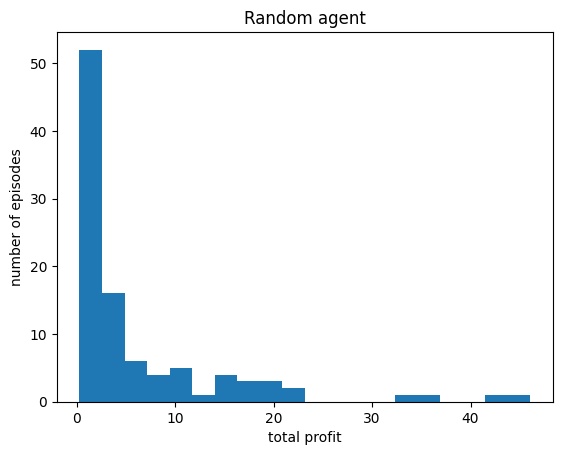

Average profit: 6.352616926390174
Max profit: 46.08024493371565
Min profit: 0.2603919053988312
Variation in profits: 8.861701831106489


In [545]:
random_profits = []
for _ in range(100):
    env1=MyCustomEnv(df=df, window_size=12, frame_bound=(start,end))
    obs = env1.reset()
    while True:
        action = env1.action_space.sample()
        obs, rewards, done, info = env1.step(action)
        if done:
            print("info", info)
            break
    random_profits.append(info['total_profit'])

# plot profits as a histogram
plt.hist(np.array(random_profits), bins=20)
plt.xlabel('total profit')
plt.ylabel('number of episodes')
plt.title('Random agent')
plt.show()

print("Average profit:", np.mean(random_profits))
print("Max profit:", np.max(random_profits))
print("Min profit:", np.min(random_profits))
print("Variation in profits:", np.std(random_profits))

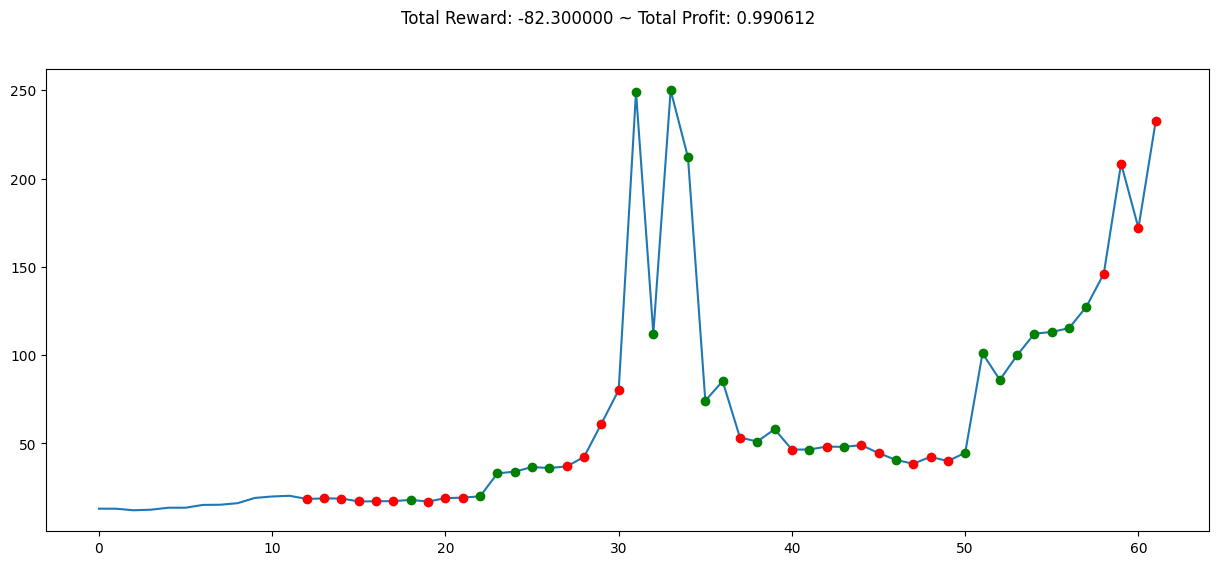

In [546]:
plt.figure(figsize=(15,6))
plt.cla()
env1.render_all()
plt.show()

### 4.3 Maximum possible profit

In [547]:

env1.max_possible_profit()

442.9502654270426